# Siamese NN
Для обучения СНС нужно много размеченных данных. иногда это крайне сложно реализовать. Более того, при появлении нового класса, необходимо переучивать сеть заново, что крайне не удобно. 

One shot Learning позволяет решить эту проблему. В ходе тренировки сети будет обучатся функция различия. Кроме того, необходимо только один экземпляр класса.  

https://github.com/eroj333/learning-cv-ml/blob/master/SNN/Learning%20Similarity%20Function.ipynb

In [22]:
import keras
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [13]:
(x_train_master, y_train_master), (x_test_master, y_test_master) = \
keras.datasets.fashion_mnist.load_data()

In [14]:
print(x_tr_master.shape)
x_train_master = np.expand_dims(x_train_master, axis=3) / 255
x_test_master = np.expand_dims(x_test_master, axis=3) / 255
print(x_tr_master.shape)

(60000, 28, 28, 1)
(60000, 28, 28, 1)


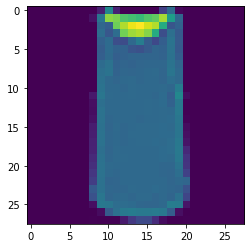

In [4]:
plt.imshow(np.squeeze(x_tr_master[2]));

In [15]:
def create_tuples(x, y, n_ways):
    y = y.flatten()
    x_t1 = []
    x_t2 = []
    target = []
    length = len(y)

    for i in range(length):
        cur_x, cur_y = x[i], y[i]
        choices = np.random.choice(length, n_ways, replace=False)
        choices_x, choices_y = x[choices], y[choices]
        for j in range(n_ways):
            _x, _y = choices_x[j], choices_y[j]
            x_t1.append(cur_x)
            x_t2.append(_x)
            target.append(1 if cur_y == _y else 0)

    return [np.array(x_t1), np.array(x_t2)], np.array(target)

def equalize_class_examples(x, y):
    x1, x2 = x
    y1 = np.where(y == 1) 

    n = y1[0].shape[0]
    y0 = np.where(y == 0)[0]
    y0 = y0[:n]

    xa = np.vstack((x1[y1], x1[y0]))
    xb = np.vstack((x2[y1], x2[y0]))

    yp = np.hstack((y[y1], y[y0]))
    return [xa, xb], yp

def get_training_data(sample_per_class=5, n_ways=5, batch_size = 32, \
                      valid_sample_per_class=2, \
                      test_sample_per_class=2):
    train_x, train_y, valid_x, valid_y, test_x, test_y = None, None, None, None, None, None

    for i in range(10):
        indices = np.argwhere(y_train_master == i)
        choice = np.random.choice(indices.shape[0], sample_per_class + valid_sample_per_class, replace=False)
        choice = indices[choice]

        sub_train_x = x_train_master[choice[:sample_per_class]]
        sub_train_y = y_train_master[choice[:sample_per_class]]

        sub_valid_x = x_train_master[choice[sample_per_class:]]
        sub_valid_y = y_train_master[choice[sample_per_class:]]

        t_indices = np.argwhere(y_test_master == i)
        t_choice = np.random.choice(t_indices.shape[0], test_sample_per_class, replace=False)
        t_choice = t_indices[t_choice]
        sub_test_x = x_test_master[t_choice]
        sub_test_y = y_test_master[t_choice]

        sub_train_x, sub_train_y, sub_valid_x, sub_valid_y, sub_test_x,\
        sub_test_y = np.squeeze(sub_train_x, axis=1), (sub_train_y), \
        np.squeeze(sub_valid_x, axis=1), (sub_valid_y), \
        np.squeeze(sub_test_x, axis=1), (sub_test_y)
        print(train_x is None)
        if(train_x is None):
            train_x, train_y, valid_x, valid_y, test_x, test_y = \
            sub_train_x, sub_train_y, sub_valid_x, sub_valid_y, \
            sub_test_x, sub_test_y
        else:
            train_x = np.vstack((train_x, sub_train_x))
            train_y = np.vstack((train_y, sub_train_y))
            #     train_x.append(sub_train_x)
            #     train_y.append(sub_train_y)

            valid_x = np.vstack((valid_x, sub_valid_x))
            valid_y = np.vstack((valid_y, sub_valid_y))
            #     valid_x.append(sub_valid_x)
            #     valid_y.append(sub_valid_y)

            test_x = np.vstack((test_x, sub_test_x))
            test_y = np.vstack((test_y, sub_test_y))

            #     test_x.append(sub_test_x)
            #     test_y.append(sub_test_y)
        print(train_x.shape, train_y.shape)
        train_x, train_y = create_tuples(train_x, train_y, n_ways)
        train_x, train_y = equalize_class_examples(train_x, train_y)
        valid_x, valid_y = create_tuples(valid_x, valid_y, n_ways)
        valid_x, valid_y = equalize_class_examples(valid_x, valid_y)
        test_x, test_y = create_tuples(test_x, test_y, n_ways)
        test_x, test_y = equalize_class_examples(test_x, test_y)

        return train_x, train_y, valid_x, valid_y, test_x, test_y

In [16]:
def visualize_data(data, data_class, n):
    n = min(len(data[0]), n)
    print("Same class: ", np.where(data_class ==1)[0].shape[0], \
          "Different class: ", np.where(data_class==0)[0].shape[0])
    fig, ax = plt.subplots(n, 2,figsize=(10,40))
    inp1, inp2 = data
    for i in range(n):
        ax[i, 0].imshow(np.squeeze(inp1[i]), cmap="gray")
        ax[i, 1].imshow(np.squeeze(inp2[i]), cmap="gray")
        # x_class = str(data_class[i].tolist())
        # ax[i, 1].set_title("class " + x_class)

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

In [18]:
train_x, train_y, valid_x, valid_y, test_x, test_y = \
get_training_data(sample_per_class=50, n_ways=10, \
                  batch_size = 32, valid_sample_per_class=20, \
                  test_sample_per_class=50)

True
(50, 28, 28, 1) (50, 1)


In [25]:
initialize_weights = keras.initializers.RandomNormal(mean=0.0, stddev=0.51,\
                                                    seed=50001)
initialize_bias = keras.initializers.RandomNormal(mean=0.0,stddev=0.1,\
                                                 seed=1221)

def get_siamese_conv_unit(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation='relu', input_shape=input_shape,\
                    kernel_initializer=initialize_weights,\
                    kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3,3), activation='relu',\
                     kernel_initializer=initialize_weights,
                    bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(100, (1,1), activation='relu', 
                     kernel_initializer=initialize_weights,
                    bias_initializer=initialize_bias, 
                    kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(1024, activation='sigmoid',
                   kernel_initializer=initialize_weights, bias_initializer=initialize_bias))
    model.add(Dropout(rate=0.05))
    
    return model


In [34]:
def get_classifier_model(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = get_siamese_conv_unit(input_shape)
    
    encoder_l = model(left_input)
    encoder_r = model(right_input)
    
    L1_layer = lambda tensors:keras.backend.abs(tensors[0] - \
                                                       tensors[1])
    L1_distance = L1_layer([encoder_l, encoder_r])
    
    prediction = Dense(1, activation='sigmoid',
                      bias_initializer=initialize_bias)(L1_distance)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    return siamese_net

In [35]:
ip_shape = (28,28,1)
model = get_classifier_model(ip_shape)
optimizer = Adam(lr=0.000001)
model.compile(loss='binary_crossentropy', optimizer=optimizer,
             metrics=['accuracy'])

In [36]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1024)         2586852     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Sub_2 (TensorFlowOp [(None, 1024)]       0           sequential_5[0][0]    

In [37]:
hist = model.fit(train_x, train_y, epochs=5, validation_data=(valid_x, valid_y))

Epoch 1/5
16/16 [==============================] - 0s 30ms/step - loss: 2.2263 - accuracy: 0.2000 - val_loss: 2.1448 - val_accuracy: 0.3150
Epoch 2/5
16/16 [==============================] - 0s 18ms/step - loss: 2.2188 - accuracy: 0.2140 - val_loss: 2.1419 - val_accuracy: 0.3250
Epoch 3/5
16/16 [==============================] - 0s 17ms/step - loss: 2.2154 - accuracy: 0.2320 - val_loss: 2.1389 - val_accuracy: 0.3350
Epoch 4/5
16/16 [==============================] - 0s 18ms/step - loss: 2.1938 - accuracy: 0.2440 - val_loss: 2.1360 - val_accuracy: 0.3350
Epoch 5/5
16/16 [==============================] - 0s 18ms/step - loss: 2.1865 - accuracy: 0.2660 - val_loss: 2.1329 - val_accuracy: 0.3450
